# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

%load_ext autoreload
%autoreload 2

In [2]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [3]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX','PRECT']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

# Years when GLENS anom = half eventual cooling found using offline calculation with this function call: closest_years_to_frac_GLENS(0.5)
t_index_feedback_half = np.where((years_feedback > 2043) & (years_feedback < 2064))[0]
t_index_control_half = np.where((years_control > 2043) & (years_control < 2064))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [4]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_frac' - Land fraction
'land_mask' - binary land mask where land fraction > 50%
'land_noice_frac' land fraction without Greenland or Antarctica
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_frac' - Land fraction\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_frac' land fraction without Greenland or Antarctica\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\n    \nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [5]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# Temp section

In [14]:
# Function to calculate global mean of given file / variable
def global_mean_data(filename, variable, weight):
    data = Dataset(filename)
    time_mean = np.mean(data.variables[variable][:],axis=0)
    global_mean = np.sum(time_mean * weight)
    return global_mean

raw_daily_data_dir = "/n/home03/pjirvine/keithfs1_pji/GLENS/raw_daily_data/"
raw_monthly_data_dir = "/n/home03/pjirvine/keithfs1_pji/GLENS/raw_monthly_data/"

daily_nc_format = "{exp}.001.cam.h3.{var}.20100101-20191230.nc"
monthly_nc_format = "{exp}.001.cam.h0.{var}.201001-201912.nc"

daily_vars = ['PRECT','LHFLX']
monthly_vars = ['PRECC','PRECL','LHFLX','QFLX']
exps = ['control','feedback']

####

exp = 'control'
weight = np.transpose(all_masks['area'])
daily_prect = global_mean_data(raw_daily_data_dir + daily_nc_format.format(exp=exp, var='PRECT'), 'PRECT', weight)

monthly_precl = global_mean_data(raw_monthly_data_dir + monthly_nc_format.format(exp=exp, var='PRECL'), 'PRECL', weight)
monthly_precc = global_mean_data(raw_monthly_data_dir + monthly_nc_format.format(exp=exp, var='PRECC'), 'PRECC', weight)

monthly_LHFLX = global_mean_data(raw_monthly_data_dir + monthly_nc_format.format(exp=exp, var='LHFLX'), 'LHFLX', weight)
monthly_QFLX = global_mean_data(raw_monthly_data_dir + monthly_nc_format.format(exp=exp, var='QFLX'), 'QFLX', weight)

print('daily:', daily_prect, 'monthly:',monthly_precl + monthly_precc)
print('monthly qflx', monthly_QFLX, 'monthly lhflx', monthly_LHFLX)
#####

# control_daily_PRECT_nc = "control.001.cam.h3.PRECT.20100101-20191230.nc"
# feedback_daily_PRECT_nc = "feedback.001.cam.h3.PRECT.20200101-20291231.nc"

# control_daily_LHFLX_nc = "control.001.cam.h3.LHFLX.20100101-20191230.nc"
# feedback_daily_LHFLX_nc = "feedback.001.cam.h3.LHFLX.20200101-20291231.nc"

# feedback_monthly_PRECC_nc = "feedback.001.cam.h0.PRECC.202001-202912.nc"

daily: 3.4900302716244805e-08 monthly: 3.489977311642505e-08
monthly qflx 3.490429975936144e-05 monthly lhflx 87.31796498927017


In [9]:
print("LH in WM-2:",monthly_LHFLX)
print("L = 2.5 MJ kg-1 (latent heat of evaporation of water)")
print("PRECT in Ms-1:",daily_prect)
print("PRECT in Kgs-1:",daily_prect*1000.)
print("LH in WM-2 / PRECT in Kgs-1 = L:",monthly_LHFLX / (daily_prect*1000.))
print("L = 2.5 MJ kg-1 (latent heat of evaporation of water)")

LH in WM-2: 87.31796498927017
L = 2.5 MJ kg-1 (latent heat of evaporation of water)
PRECT in Ms-1: 3.4900302716244805e-08
PRECT in Kgs-1: 3.4900302716244806e-05
LH in WM-2 / PRECT in Kgs-1 = L: 2501925.7196478946
L = 2.5 MJ kg-1 (latent heat of evaporation of water)


In [10]:
Dataset(raw_monthly_data_dir + monthly_nc_format.format(exp='control', var='LHFLX')).variables['LHFLX']

<class 'netCDF4._netCDF4.Variable'>
float32 LHFLX(time, lat, lon)
    units: W/m2
    long_name: Surface latent heat flux
    cell_methods: time: mean
unlimited dimensions: time
current shape = (120, 192, 288)
filling on, default _FillValue of 9.969209968386869e+36 used

# INSERT FIGURE SECTIONS HERE

In [11]:
def median_y_hist2d(hist2d_out, thresh_factor=50):

    """
    returns y values for median with None where less than threshold factor times the minimum weight.
    (and corresponding x values)
    """
    
    # unpack hist2d_out
    h, x, y, image = hist2d_out

    # define centres from edges
    def centres(x):
        x_1 = np.roll(x,-1)
        return ((x + x_1) / 2)[0:-1]

    x_mid = centres(x)
    y_mid = centres(y)

    # this function calculates the median
    def med_y(y_mid,x_index,weight):

        # Define threshold for calculating median and interquartiles
        min_weight = np.nanmin(h)
        med_thresh = min_weight * thresh_factor
    #     iq_thresh = min_weight * 20

        # Convert nan to zero weight
        weight = np.nan_to_num(weight)

        if np.sum(weight[x_index,:]) > med_thresh:
            return weighted_quantile(y_mid, 0.5, sample_weight=weight[x_index,:])
        else:
            return None

    median_y = [med_y(y_mid,IDX,h) for IDX in range(len(x_mid))]
    
    return x_mid, median_y

def quant_y_hist2d(hist2d_out, quant=0.5, thresh_factor=50):

    """
    returns y values for median with None where less than threshold factor times the minimum weight.
    (and corresponding x values)
    """
    
    # unpack hist2d_out
    h, x, y, image = hist2d_out

    # define centres from edges
    def centres(x):
        x_1 = np.roll(x,-1)
        return ((x + x_1) / 2)[0:-1]

    x_mid = centres(x)
    y_mid = centres(y)

    # this function calculates the median
    def quant_y(y_mid,x_index,quant,weight):

        # Define threshold for calculating median and interquartiles
        min_weight = np.nanmin(h)
        med_thresh = min_weight * thresh_factor
    #     iq_thresh = min_weight * 20

        # Convert nan to zero weight
        weight = np.nan_to_num(weight)

        if np.sum(weight[x_index,:]) > med_thresh:
            return weighted_quantile(y_mid, quant, sample_weight=weight[x_index,:])
        else:
            return None

    quant_y = [quant_y(y_mid,IDX,quant,h) for IDX in range(len(x_mid))]
    
    return x_mid, quant_y


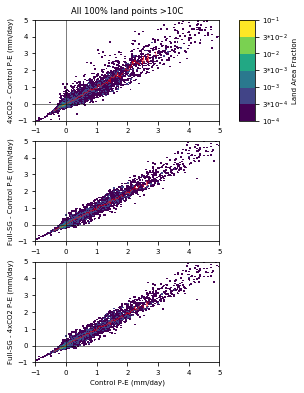

In [27]:
"""
Set up plot options
"""
from matplotlib.gridspec import GridSpec

out_dir=''

out_name = 'P-E_anoms_vs_control_P-E_>10C_100%land'

title = 'All 100% land points >10C'

# apply SAT > 10 C mask
sat = True

var = 'P-E'

land_mask_100 = all_masks['land_frac'].flatten() == 100.
weight = (land_mask_100 * all_masks['land_area'].flatten()) / np.sum((land_mask_100 * all_masks['land_area'].flatten()))

thresh_factor=10.

plot_x = all_data[var,'Baseline'][0].flatten()

# # CO2 - control
# plot_y1 = ((all_data[var,'RCP8.5'][0] - all_data[var,'Baseline'][0]) / all_data[var,'Baseline'][1]).flatten()
# # SRM - control
# plot_y2 = ((all_data[var,'Full-GLENS'][0] - all_data[var,'Baseline'][0]) / all_data[var,'Baseline'][1]).flatten()
# # SRM - 4xCO2
# plot_y3 = ((all_data[var,'Full-GLENS'][0] - all_data[var,'RCP8.5'][0]) / all_data[var,'Baseline'][1]).flatten()

# CO2 - control
plot_y1 = all_data[var,'RCP8.5'][0].flatten()
# SRM - control
plot_y2 = all_data[var,'Full-GLENS'][0].flatten()
# SRM - 4xCO2
plot_y3 = all_data[var,'Full-GLENS'][0].flatten()

# apply SAT > 10C mask
if sat:
    sat_ctrl = all_data['TREFHT','Baseline'][0].flatten()
    sat_mask = sat_ctrl > 10.
    
    sat_weight = sat_mask * weight
    weight = sat_weight / np.sum(sat_weight)
    
# Dont need lowest..
bounds = [1.e-4,3.e-4,1.e-3,3.e-3,1.e-2,3.e-2,1.e-1]
labels = ['$10^{-4}$','3*$10^{-4}$','$10^{-3}$','3*$10^{-3}$','$10^{-2}$','3*$10^{-2}$','$10^{-1}$']

xlims = [-1,5]
ylims = [-1,5]

nbins = 200

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

"""
Set up figure
"""

f = plt.figure(figsize=cm2inch(10,16))
plt.rcParams.update({'font.size': 7})

gs = GridSpec(3, 2, width_ratios=[12,1], height_ratios=[1,1,1])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[2,0])
cax = plt.subplot(gs[0,1])
ax4 = plt.subplot(gs[1,1])

"""
Make 2d hist plots
"""

# Plot CO2 - control anomaly
img1 = ax1.hist2d(plot_x, plot_y1, bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

# Plot median Y value where >50x minimum weight
x,y = median_y_hist2d(img1, thresh_factor=thresh_factor)
ax1.plot(x,y,color='r',lw=0.5)

ax1.set_title(title)
ax1.set_ylabel('4xCO2 - Control P-E (mm/day)')
ax1.axhline(0.,color='k',lw=0.5)
ax1.axvline(0.,color='k',lw=0.5)

plt.axis('scaled')

# plot SRM - control anomaly
img2 = ax2.hist2d(plot_x, plot_y2, bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

# Plot median Y value where >50x minimum weight
x,y = median_y_hist2d(img2, thresh_factor=thresh_factor)
ax2.plot(x,y,color='r',lw=0.5)

ax2.set_ylabel('Full-SG - Control P-E (mm/day)')
ax2.axhline(0.,color='k',lw=0.5)
ax2.axvline(0.,color='k',lw=0.5)

plt.axis('scaled')

# plot SRM - control anomaly
img3 = ax3.hist2d(plot_x, plot_y3, bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

# Plot median Y value where >50x minimum weight
x,y = median_y_hist2d(img3, thresh_factor=thresh_factor)
ax3.plot(x,y,color='r',lw=0.5)

ax3.set_xlabel('Control P-E (mm/day)')
ax3.set_ylabel('Full-SG - 4xCO2 P-E (mm/day)')
ax3.axhline(0.,color='k',lw=0.5)
ax3.axvline(0.,color='k',lw=0.5)

plt.axis('scaled')

"""
Colorbar and finishing up
"""

cbar = f.colorbar(img1[3], cax=cax, ticks=bounds, format='%0.0e')
cbar.set_ticklabels(labels)
cbar.set_label('Land Area Fraction')

ax4.axis('off') # needed due to cbar plotting issue

plt.savefig(out_dir+out_name+'.png', format='png', dpi=480)
plt.savefig(out_dir+out_name+'.eps', format='eps', dpi=480)

plt.show()

In [96]:
np.sum(all_data['P-E','RCP8.5'][0] * all_masks['area'])
np.sum(all_data['PRECT','RCP8.5'][0] * all_masks['area'])

3.266488022334734

In [94]:
np.sum(all_data['P-E','Baseline'][0] * all_masks['area'])

-0.3240704243749209

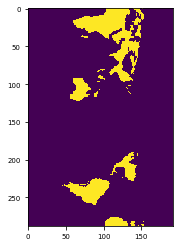

In [39]:
plt.imshow((all_data['TREFHT','Baseline'][0] > 10.) * np.transpose(all_masks['land_frac']) == 100.)

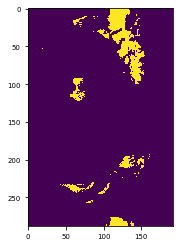

In [18]:
plt.imshow((all_data[var,'Baseline'][0] < 0) * all_masks['land_frac'] == 100.)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

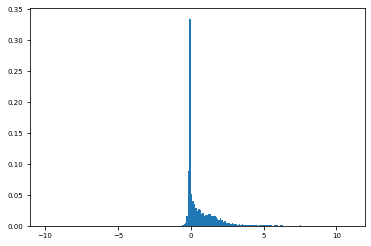

In [13]:
plt.hist(plot_x, bins=[x*0.1-10 for x in range(210)], weights=weight)

# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [ ]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [ ]:
nc_data.shape

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

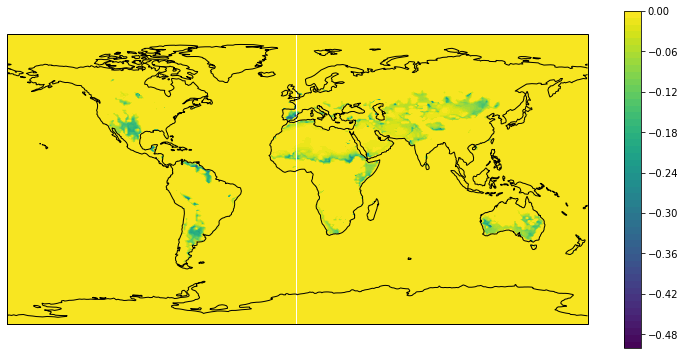

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [28]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()
mask = all_masks['land_noice_mask']#.transpose()

data = all_data[('P-E','Baseline')][0] * (all_data[('P-E','Baseline')][0] < 0) * (all_data[('P-E','Baseline')][0] > -0.5) * mask
# data = all_data[('P-E','Full-GLENS')][0] * (all_data[('P-E','Full-GLENS')][0] < 0) * (all_data[('P-E','Full-GLENS')][0] > -1.0) * mask
# data = all_data[('P-E','RCP8.5')][0] * (all_data[('P-E','RCP8.5')][0] < 0) * (all_data[('P-E','RCP8.5')][0] > -1.0) * mask
# data = np.transpose(all_masks['land_frac'])

fig = plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

CS = plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

fig.colorbar(CS) #cm.ScalarMappable(),ax=ax)

plt.show()

data

In [ ]:
plt.imshow(all_data[('P-E','RCP8.5')][0])